In [1]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from sys import maxint

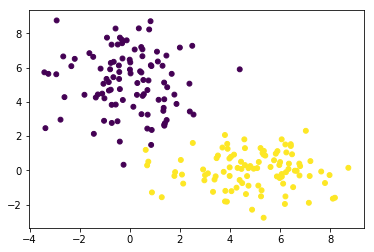

In [2]:
### Setup
# set random seed
rand.seed(42)

# 2 clusters
# not that both covariance matrices are diagonal
mu1 = [0, 5]
sig1 = [ [2, 0], [0, 3] ]

mu2 = [5, 0]
sig2 = [ [4, 0], [0, 1] ]

# generate samples
x1, y1 = np.random.multivariate_normal(mu1, sig1, 100).T
x2, y2 = np.random.multivariate_normal(mu2, sig2, 100).T

xs = np.concatenate((x1, x2))
ys = np.concatenate((y1, y2))
labels = ([1] * 100) + ([2] * 100)

data = {'x': xs, 'y': ys, 'label': labels}
df = pd.DataFrame(data=data)

# inspect the data
df.head()
df.tail()

fig = plt.figure()
plt.scatter(data['x'], data['y'], 24, c=data['label'])

### Expectation-maximization

# initial guesses - intentionally bad
guess = { 'mu1': [1,1],
          'sig1': [ [1, 0], [0, 1] ],
          'mu2': [4,4],
          'sig2': [ [1, 0], [0, 1] ],
          'lambda': [0.4, 0.6]
        }

# probability that a point came from a Guassian with given parameters
# note that the covariance must be diagonal for this to work
def prob(val, mu, sig, lam):
  p = lam
  for i in range(len(val)):
    p *= norm.pdf(val[i], mu[i], sig[i][i])
  return p


# assign every data point to its most likely cluster
def expectation(dataFrame, parameters):
  for i in range(dataFrame.shape[0]):
    x = dataFrame['x'][i]
    y = dataFrame['y'][i]
    p_cluster1 = prob([x, y], list(parameters['mu1']), list(parameters['sig1']), parameters['lambda'][0] )
    p_cluster2 = prob([x, y], list(parameters['mu2']), list(parameters['sig2']), parameters['lambda'][1] )
    if p_cluster1 > p_cluster2:
      dataFrame['label'][i] = 1
    else:
      dataFrame['label'][i] = 2
  return dataFrame


# update estimates of lambda, mu and sigma
def maximization(dataFrame, parameters):
  points_assigned_to_cluster1 = dataFrame[dataFrame['label'] == 1]
  points_assigned_to_cluster2 = dataFrame[dataFrame['label'] == 2]
  percent_assigned_to_cluster1 = len(points_assigned_to_cluster1) / float(len(dataFrame))
  percent_assigned_to_cluster2 = 1 - percent_assigned_to_cluster1
  parameters['lambda'] = [percent_assigned_to_cluster1, percent_assigned_to_cluster2 ]
  parameters['mu1'] = [points_assigned_to_cluster1['x'].mean(), points_assigned_to_cluster1['y'].mean()]
  parameters['mu2'] = [points_assigned_to_cluster2['x'].mean(), points_assigned_to_cluster2['y'].mean()]
  parameters['sig1'] = [ [points_assigned_to_cluster1['x'].std(), 0 ], [ 0, points_assigned_to_cluster1['y'].std() ] ]
  parameters['sig2'] = [ [points_assigned_to_cluster2['x'].std(), 0 ], [ 0, points_assigned_to_cluster2['y'].std() ] ]
  return parameters

# get the distance between points
# used for determining if params have converged
def distance(old_params, new_params):
  dist = 0
  for param in ['mu1', 'mu2']:
    for i in range(len(old_params)):
      dist += (old_params[param][i] - new_params[param][i]) ** 2
  return dist ** 0.5

# loop until parameters converge
shift = maxint
epsilon = 0.01
iters = 0
df_copy = df.copy()
# randomly assign points to their initial clusters
df_copy['label'] = map(lambda x: x+1, np.random.choice(2, len(df)))
params = pd.DataFrame(guess)

In [3]:
while shift > epsilon:
    iters += 1
    # E-step
    updated_labels = expectation(df_copy.copy(), params)

    # M-step
    updated_parameters = maximization(updated_labels, params.copy())

    # see if our estimates of mu have changed
    # could incorporate all params, or overall log-likelihood
    shift = distance(params, updated_parameters)

    # logging
    print("iteration {}, shift {}".format(iters, shift))

    # update labels and params for the next iteration
    df_copy = updated_labels
    params = updated_parameters

    fig = plt.figure()

/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


iteration 1, shift 1.3127694715
iteration 2, shift 0.674256868591
iteration 3, shift 0.801750609507
iteration 4, shift 0.2504144625
iteration 5, shift nan


In [8]:
plt.show()